## Pixel and Image Classification on a Sentinel-2 Time Series

In [3]:
# import some modules
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
# utility
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
#plt.rcParams["figure.figsize"] = (12, 5)
#mpl.rcParams['figure.dpi']= 300

2022-11-28 20:21:59.926196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 20:21:59.926256: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
path = "/home/nikkord/code/nikkordalis/Pixel-vs-Image-Classification-on-Sentinel-2/Pixel-vs-Image-Classification-on-Sentinel-2/data"
# Check current working directory.
retval = os.getcwd()
print ("Current working directory %s" % retval)

# Now change the directory
os.chdir( path )

# Check current working directory.
retval = os.getcwd()

Current working directory /home/nikkord/code/nikkordalis/Pixel-vs-Image-Classification-on-Sentinel-2/Pixel-vs-Image-Classification-on-Sentinel-2


In [12]:
# variables for data filepaths
# download the images from the google drive
sentinel_fp = '04_S2A_MSIL1C_20160819T091032_N0204_R050_T34SGH_20160819T091909_Athens2016_Aug.tif'
sentinel_fp_1 = '04_S2B_MSIL1C_20190809T090559_N0208_R050_T34SGH_20190809T112133_Athens2019_Aug.tif'
sentinel_fp_2 = '04_S2B_MSIL1C_20200803T090559_N0209_R050_T34SGH_20200803T113141_Athens2020_Aug.tif'
label_fp = '2016.shp'
label_fp_1 = '2019_A.shp'
label_fp_2 = '2020.shp'
# variable with band list
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
# variable with center wavelength for each band (in nanometers)
band_wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

In [13]:
# load the sentinel scene and print the metadata
full_dataset = rasterio.open(sentinel_fp) #2016
full_dataset_1 = rasterio.open(sentinel_fp_1) #2019
full_dataset_2 = rasterio.open(sentinel_fp_2) #2020

In [14]:
# load training data 2016, 2019, 2020
X = np.load('2016_pixel_bands.npy')
y = np.load('2016_pixel_band_classes.npy')
X_1 = np.load('2019_pixel_bands.npy')
y_1 = np.load('2019_pixel_band_classes.npy')
X_2 = np.load('2020_pixel_bands.npy')
y_2 = np.load('2020_pixel_band_classes.npy')

# load prediction image 2016
X_pred = full_dataset.read()
# adjust the axis to move band axis to the last dimension
X_pred = np.moveaxis(X_pred, 0, -1)
# finally reshape to create array of pixels and values
X_pred = X_pred.reshape(-1, full_dataset.meta['count'])

# load prediction image 2019
X_pred_1 = full_dataset_1.read()
X_pred_1 = np.moveaxis(X_pred_1, 0, -1)
X_pred_1 = X_pred_1.reshape(-1, full_dataset_1.meta['count'])

# load prediction image 2020
X_pred_2 = full_dataset_2.read()
X_pred_2 = np.moveaxis(X_pred_2, 0, -1)
X_pred_2 = X_pred_2.reshape(-1, full_dataset_2.meta['count'])

In [15]:
# parameters
reduce_bands = True
# shuffle X, y

#2016
rp = np.random.permutation(len(X))
X = X[rp]
y = y[rp]

#2019
rp_1 = np.random.permutation(len(X_1))
X_1 = X_1[rp_1]
y_1 = y_1[rp_1]

#2020
rp_2 = np.random.permutation(len(X_2))
X_2 = X_2[rp_2]
y_2 = y_2[rp_2]

In [16]:
# show label counts
# 2016
df = pd.DataFrame(X)
df['label'] = y
print("The labels for the year 2016 \n", df.label.value_counts())
# 2019
df_1 = pd.DataFrame(X_1)
df_1['label'] = y_1
print("The labels for the year 2019 \n",df_1.label.value_counts())
# 2020
df_2 = pd.DataFrame(X_2)
df_2['label'] = y_2
print("The labels for the year 2020 \n",df_2.label.value_counts())

The labels for the year 2016 
 vegetation    241
cement        216
bare soil     173
rocks         169
asphalt       154
water          86
tiled roof     79
Name: label, dtype: int64
The labels for the year 2019 
 bare soil     206
vegetation    193
cement        165
rocks         112
water         112
asphalt        91
tiled roof     69
Name: label, dtype: int64
The labels for the year 2020 
 bare soil     121
cement        114
vegetation     89
water          85
asphalt        71
tiled roof     69
rocks          48
Name: label, dtype: int64


**plot density of data point**

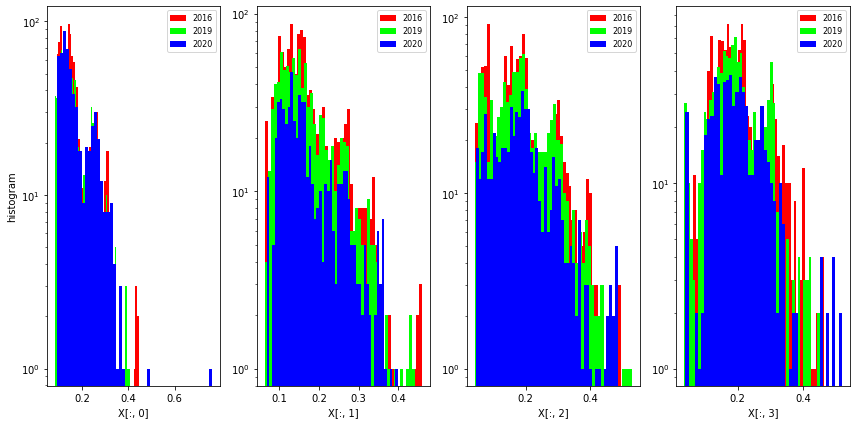

In [17]:
# plot density of data point for each dimension to see if there are outliers
if reduce_bands:
    fig, axs = plt.subplots(1, 4, figsize=(12,6))
else:
    fig, axs = plt.subplots(2, 5)
axs = axs.flatten()


colors = ['red']
axs[0].set_ylabel('histogram')

# 2016
for i, ax in enumerate(axs):
    ax.hist(X[:, i], bins=50,color=colors, label="2016" )
    ax.set_xlabel('X[:, {}]'.format(i))
    ax.set_yscale('log')
    ax.legend(prop={'size': 8})
fig.tight_layout()
# 2019
colors_1 = ['lime']
for i, ax in enumerate(axs):
    ax.hist(X_1[:, i], bins=50,color=colors_1, label="2019")
    ax.set_xlabel('X[:, {}]'.format(i))
    ax.set_yscale('log')
    ax.legend(prop={'size': 8})
fig.tight_layout()
# 2020
colors_2 = ['blue']
for i, ax in enumerate(axs):
    ax.hist(X_2[:, i], bins=50,color=colors_2, label="2020")
    ax.set_xlabel('X[:, {}]'.format(i))
    ax.set_yscale('log')
    ax.legend(prop={'size': 8})
fig.tight_layout()

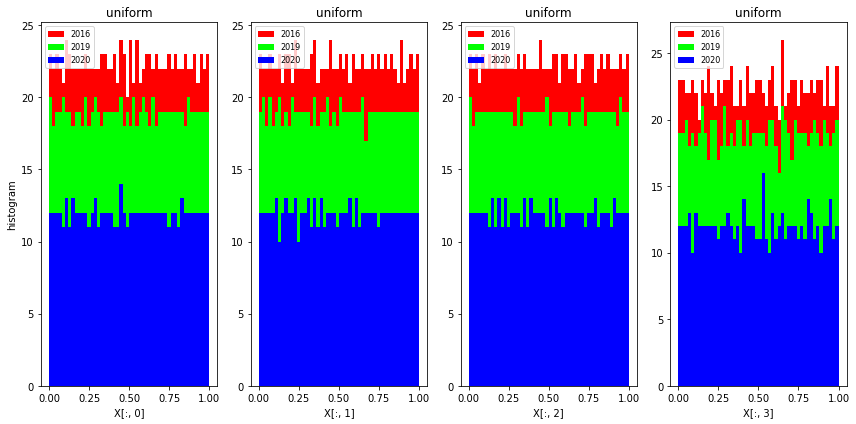

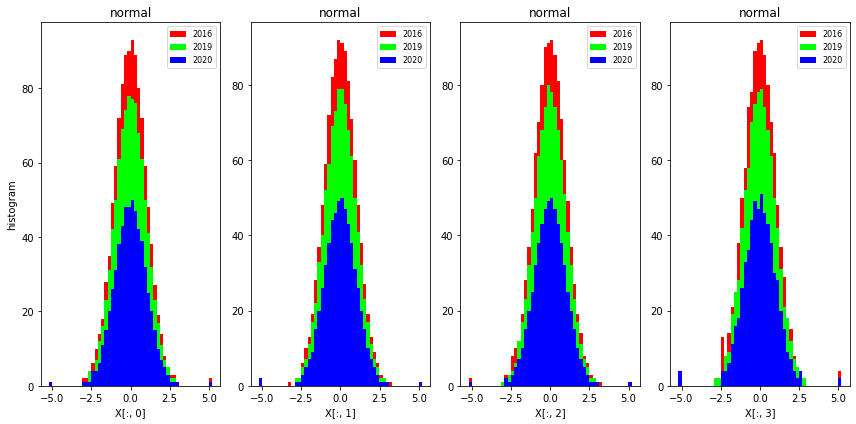

In [18]:
# try QuantileTransformer
for output_distribution in ['uniform', 'normal']:
    X_ = QuantileTransformer(output_distribution=output_distribution).fit_transform(X)
    X_1_ = QuantileTransformer(output_distribution=output_distribution).fit_transform(X_1)
    X_2_ = QuantileTransformer(output_distribution=output_distribution).fit_transform(X_2)
    if reduce_bands:
        fig, axs = plt.subplots(1, 4,figsize=(12,6))
    else:
        fig, axs = plt.subplots(2, 5)
    axs = axs.flatten()
    
      # 2016
    axs[0].set_ylabel('histogram')
    colors = ['red']
    for i, ax in enumerate(axs.flatten()):
        ax.hist(X_[:, i], bins=50, color=colors, label="2016")
        ax.set_title(output_distribution)
        ax.set_xlabel('X[:, {}]'.format(i))
        ax.legend(prop={'size': 8})
        # ax.set_yscale('log')
    fig.tight_layout() 
    # 2019
    colors_1 = ["lime"]
    axs[0].set_ylabel('histogram')
    for i, ax in enumerate(axs.flatten()):
        ax.hist(X_1_[:, i], bins=50, color=colors_1, label="2019")
        ax.set_title(output_distribution)
        ax.set_xlabel('X[:, {}]'.format(i))
        ax.legend(prop={'size': 8})
        # ax.set_yscale('log')
    fig.tight_layout()
    # 2020
    colors_2 = ["blue"]
    axs[0].set_ylabel('histogram')
    for i, ax in enumerate(axs.flatten()):
        ax.hist(X_2_[:, i], bins=50, color=colors_2, label="2020")
        ax.set_title(output_distribution)
        ax.set_xlabel('X[:, {}]'.format(i))
        ax.legend(prop={'size': 8})
        # ax.set_yscale('log')
    fig.tight_layout()

**Comparing Accuracy of Different Models**


All the models that were used were part of the supervised learning method. In this case the computer system provides examples of input and desired output, ie the data have been previously labeled and the aim is to derive a general rule for assigning the input to the desired output. In terms of the use of the three models (KNN, SVC and MLP) it had to be developped a function that evaluate the models with the help of the cross - validation score.

In [19]:
# define function to validate models
def evaluate_model(clf,clf_1,clf_2, cv):
    # train model
    clf.fit(X, y)        #2016
    clf_1.fit(X_1, y_1)  #2019
    clf_2.fit(X_2, y_2)  #2010
    # compute cross-validation score
    scores = cross_val_score(clf, X, y, cv=cv)
    scores_1 = cross_val_score(clf_1, X_1, y_1, cv=cv)
    scores_2 = cross_val_score(clf_2, X_2, y_2, cv=cv)
    # compute mean score and 95% confidence interval of the score estimate
    print("Accuracy 2016: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print("Accuracy 2019: %0.4f (+/- %0.4f)" % (scores_1.mean(), scores_1.std() * 2))
    print("Accuracy 2020: %0.4f (+/- %0.4f)" % (scores_2.mean(), scores_2.std() * 2))
    # return to keep track
    return clf, clf_1, clf_2, scores.mean(), scores.std()*2 , scores_1.mean(), scores_1.std()*2 ,scores_2.mean(), scores_2.std()*2     

In [20]:
# keep track of scores for different models
#2016
names = []      
clfs = []
scores = []
scores_std = []
#2019
names_1 = []     
clfs_1 = []
scores_1 = []
scores_std_1 = []
#2020
names_2 = []
clfs_2 = []
scores_2 = []
scores_std_2 = []

**KNN model**

Τhis categorization technique is based on the use of distance-based measures. Only the K closest assignments to the training set are taken into account below. The new item is placed in the category that contains the most items from the set of the closest data. Two issues must be decided in order to fully define the algorithm:
The definition of the distance between two snapshots,  which will express the proximity, and the value of k.

In [21]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf_1 = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf_2 = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [22]:
# classifier
param_grid={'kneighborsclassifier__weights':['uniform', 'distance'] ,'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True,verbose=0)     #2016
clf_1 = GridSearchCV(estimator=clf_1, param_grid=param_grid, cv=10, refit=True,verbose=0) #2019
clf_2 = GridSearchCV(estimator=clf_2, param_grid=param_grid, cv=10, refit=True,verbose=0) #2020

# evaluate
cv = StratifiedKFold(n_splits=5)
# cv = StratifiedShuffleSplit(n_splits=50)
clf, clf_1,clf_2, score, score_std, score_1, score_std_1,score_2, score_std_2 = evaluate_model(clf,clf_1,clf_2, cv)

# keep track of results
names.append('KNN_layers_2016')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

names_1.append('KNN_layers_2019')
clfs_1.append(clf_1)
scores_1.append(score_1)
scores_std_1.append(score_std_1)

names_2.append('KNN_layers_2020')
clfs_2.append(clf_2)
scores_2.append(score_2)
scores_std_2.append(score_std_2)

Accuracy 2016: 0.9812 (+/- 0.0154)
Accuracy 2019: 0.9420 (+/- 0.0298)
Accuracy 2020: 0.9330 (+/- 0.0145)


In [23]:
# save results
cv_results = pd.DataFrame(clf.cv_results_)      #2016
cv_results_1 = pd.DataFrame(clf_1.cv_results_)  #2019
cv_results_2 = pd.DataFrame(clf_2.cv_results_)  #2020

**SVC model**

The key feature is that this model trained to be able to separate the different data in two classes, after given some training data. Specifically, in a representation of the training samples in the field, an SVM model tries to find and select the optimal ‘decision boundary’ between the data, which will determine which class each individual sample belongs to.

In [24]:
# classifier
clf = make_pipeline(StandardScaler(), svm.SVC())
clf_1 = make_pipeline(StandardScaler(), svm.SVC())
clf_2 = make_pipeline(StandardScaler(), svm.SVC())
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [25]:
%%time
# perform grid search to find optimal polynomial degree
param_grid={'svc__degree': [2, 3, 4, 5], 'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, refit=True,verbose=0)
clf_1 = GridSearchCV(estimator=clf_1, param_grid=param_grid, cv=10, refit=True,verbose=0)
clf_2 = GridSearchCV(estimator=clf_2, param_grid=param_grid, cv=10, refit=True,verbose=0)
# evaluate
cv = StratifiedKFold(n_splits=5)
# cv = StratifiedShuffleSplit(n_splits=50)
clf, clf_1,clf_2, score, score_std, score_1, score_std_1,score_2, score_std_2 = evaluate_model(clf,clf_1,clf_2, cv)

# keep track of results
names.append('SVC_layers_2016')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

names_1.append('SVC_layers_2019')
clfs_1.append(clf_1)
scores_1.append(score_1)
scores_std_1.append(score_std_1)

names_2.append('SVC_layers_2020')
clfs_2.append(clf_2)
scores_2.append(score_2)
scores_std_2.append(score_std_2)

Accuracy 2016: 0.9750 (+/- 0.0165)
Accuracy 2019: 0.9346 (+/- 0.0302)
Accuracy 2020: 0.9246 (+/- 0.0259)
CPU times: user 31.1 s, sys: 3.41 ms, total: 31.2 s
Wall time: 31.2 s


In [26]:
# save results 
cv_results = pd.DataFrame(clf.cv_results_)      # 2016
cv_results_1 = pd.DataFrame(clf_1.cv_results_)  # 2019 
cv_results_2 = pd.DataFrame(clf_2.cv_results_)  # 2020 

**MLPClassifier**

 The main difference between MLP architectures and these simple sensors is the existence of one or more hidden levels. These extra levels of neurons allow the design and creation of TNDs that respond to more demanding problems since:
The number of neurons (and the degree of freedom) of the TND increases and therefore the synapses that contain additional information - weights. It is possible to customize more complex functions to be able to better describe and then separate the input data. The signal is streamed again from the input level to the output level (feedforward), there is simply the possibility of applying a non-linear activation function between the input level and the next hidden level. 

In [27]:
# classifier
clf = make_pipeline(StandardScaler(), MLPClassifier())
clf_1 = make_pipeline(StandardScaler(), MLPClassifier())
clf_2 = make_pipeline(StandardScaler(), MLPClassifier())
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'mlpclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclassifier__learning_rate_init', 'mlpclassifier__max_fun', 'mlpclassifier__max_iter', 'mlpclassifier__momentum', 'mlpclassifier__n_iter_no_change', 'mlpclassifier__nesterovs_momentum', 'mlpclassifier__power_t', 'mlpclassifier__random_state', 'mlpclassifier__shuffle', 'mlpclassifier__solver', 'mlpclassifier__tol', 'mlpclassifier__validation_fraction', 'mlpclassifier__verbose', 'mlpclassifier__warm_start'])

In [28]:
%%time
# perform grid search to find optimal polynomial degree
param_grid = {"mlpclassifier__hidden_layer_sizes":[100, 150], 'mlpclassifier__activation':['identity', 'logistic', 'tanh', 'relu']}
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, refit=True)
clf_1 = GridSearchCV(estimator=clf_1, param_grid=param_grid, cv=5, refit=True)
clf_2 = GridSearchCV(estimator=clf_2, param_grid=param_grid, cv=5, refit=True)
# evaluate
cv = StratifiedKFold(n_splits=5)
# cv = StratifiedShuffleSplit(n_splits=50)
clf, clf_1,clf_2, score, score_std, score_1, score_std_1,score_2, score_std_2 = evaluate_model(clf,clf_1,clf_2, cv)
# keep track of results
names.append('MLPClassifier_2016')
clfs.append(clf)
scores.append(score)
scores_std.append(score_std)

names_1.append('MLPClassifier_2019')
clfs_1.append(clf_1)
scores_1.append(score_1)
scores_std_1.append(score_std_1)

names_2.append('MLPClassifier_2020')
clfs_2.append(clf_2)
scores_2.append(score_2)
scores_std_2.append(score_std_2)

Accuracy 2016: 0.9830 (+/- 0.0119)
Accuracy 2019: 0.9525 (+/- 0.0065)
Accuracy 2020: 0.9297 (+/- 0.0269)
CPU times: user 3min 51s, sys: 0 ns, total: 3min 51s
Wall time: 3min 51s


In [29]:
# show results 2016
cv_results = pd.DataFrame(clf.cv_results_)       # 2016
cv_results_1 = pd.DataFrame(clf_1.cv_results_)   # 2019
cv_results_2 = pd.DataFrame(clf_2.cv_results_)   # 2020

**(d) For each scene: using the model with the highest accuracy, predict the land use labels on the entire scene.**


In [30]:
res_2016 = pd.DataFrame(index=names, data={'clf': clfs, 'score': scores, 'score_std': scores_std,})
res_2016  # .sort_values('score')

,clf,score,score_std
KNN_layers_2016,"GridSearchCV(cv=10,\n estimator=Pi...",0.981218,0.015363
SVC_layers_2016,"GridSearchCV(cv=10,\n estimator=Pi...",0.974960,0.016543
MLPClassifier_2016,"GridSearchCV(cv=5,\n estimator=Pip...",0.982996,0.011930


In [31]:
res_2019 = pd.DataFrame(index=names_1, data={'clf': clfs_1, 'score': scores_1, 'score_std': scores_std_1,})
res_2019  # .sort_values('score')

,clf,score,score_std
KNN_layers_2019,"GridSearchCV(cv=10,\n estimator=Pi...",0.941999,0.029759
SVC_layers_2019,"GridSearchCV(cv=10,\n estimator=Pi...",0.934609,0.030233
MLPClassifier_2019,"GridSearchCV(cv=5,\n estimator=Pip...",0.952537,0.006519


In [32]:
res_2020 = pd.DataFrame(index=names_2, data={'clf': clfs_2, 'score': scores_2, 'score_std': scores_std_2,})
res_2020  # .sort_values('score')

,clf,score,score_std
KNN_layers_2020,"GridSearchCV(cv=10,\n estimator=Pi...",0.933025,0.014471
SVC_layers_2020,"GridSearchCV(cv=10,\n estimator=Pi...",0.924636,0.025864
MLPClassifier_2020,"GridSearchCV(cv=5,\n estimator=Pip...",0.929678,0.026944


In [33]:
# store results
nbands = 4

res_2016.to_pickle('2016_model_results_'+str(nbands)+'_bands.pkl'.format(nbands))
res_2016 = pd.read_pickle('2016_model_results_4_bands.pkl')

res_2019.to_pickle('2019_model_results_'+str(nbands)+'_bands.pkl'.format(nbands))
res_2019 = pd.read_pickle('2019_model_results_4_bands.pkl')

res_2020.to_pickle('2020_model_results_'+str(nbands)+'_bands.pkl'.format(nbands))
res_2020 = pd.read_pickle('2020_model_results_4_bands.pkl')

In [35]:
# which model do we want to check? select by score!
clf_2016 = res_2016.loc[res_2016['score'] == res_2016['score'].max(), 'clf'].values[0]      # 2016 MLP
clf_2019 = res_2019.loc[res_2019['score'] == res_2019['score'].max(), 'clf'].values[0]     # 2019 MLP
clf_2020 = res_2020.loc[res_2020['score'] == res_2020['score'].max(), 'clf'].values[0]     # 2010 KNN

The model that selected by the score for the predictions in two images (2016 and 2019) was the MLP while in the last image 2020 the best score had the KNN model. The best score for the image 2016 is 0.983905 (MLP), for the image 2019 is 0.951484 (MLP) and  for the image 2020 is 0.943053 (KNN).

In [75]:
# classifier name
classifier_name_2016 = res_2016.loc[res_2016['score'] == res_2016['score'].max(), 'clf'].index.values[0]
classifier_name_2019 = res_2019.loc[res_2019['score'] == res_2019['score'].max(), 'clf'].index.values[0]
classifier_name_2020 = res_2020.loc[res_2020['score'] == res_2020['score'].max(), 'clf'].index.values[0]

In [76]:
# save width and height for later reshaping
width = full_dataset.meta['width']  #2016
height = full_dataset.meta['height']#2016

width_1 = full_dataset_1.meta['width'] #2019
height_1 = full_dataset_1.meta['height'] #2019

width_2 = full_dataset_2.meta['width'] #2020
height_2 = full_dataset_2.meta['height'] #2020

In [38]:
# original shape of scene
orig_shape = (height, width)
orig_shape_1 = (height_1, width_1)
orig_shape_2 = (height_2, width_2)
# run prediction on the image
y_pred = clf.predict(X_pred)
y_pred_1= clf_1.predict(X_pred_1)
y_pred_2= clf_1.predict(X_pred_2)
# reshape y back to a 2D matrix for visualization
y_pred_img = y_pred.reshape(orig_shape)
y_pred_img_1 = y_pred_1.reshape(orig_shape_1)
y_pred_img_2 = y_pred_2.reshape(orig_shape_2)

In [61]:
# reclassify the string label names as numeric values
labels = ['asphalt', 'bare soil' ,'cement', 'rocks' ,'tiled roof','vegetation', 'water']

for i, label in enumerate(labels):
    y_pred_img[y_pred_img == label] = i
    y_pred_img_1[y_pred_img_1 == label] = i
    y_pred_img_2[y_pred_img_2 == label] = i
y_pred_img_2016 = y_pred_img.astype(int)
y_pred_img_2019 = y_pred_img_1.astype(int)
y_pred_img_2020 = y_pred_img_2.astype(int)

**Image 2016**

In [63]:
rgb_fp_2016 = '04_sentinel_Athens_2016_rgb_8bit.jpg'
rgb_fp_2019 = '04_sentinel_Athens_2019_rgb_8bit.jpg'
rgb_fp_2020 = '04_sentinel_Athens_2020_rgb_8bit.jpg'

Text(0.5, 1.0, 'MLPClassifier_2016')

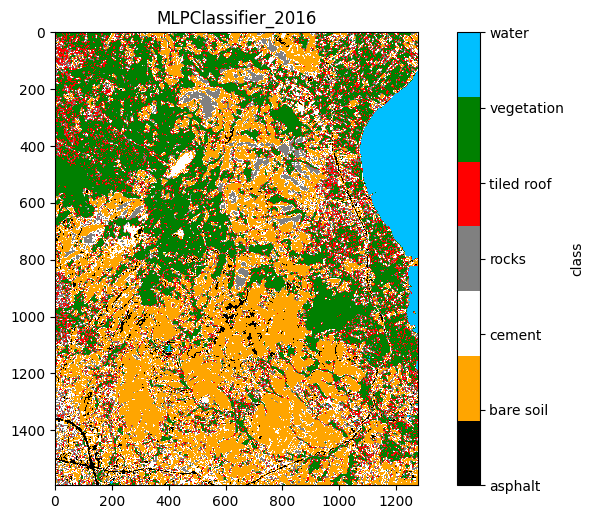

In [97]:
from matplotlib import colors
img_2016 = mpimg.imread(rgb_fp_2016) 
#plt.figure(figsize=(10,6),dpi=300)

plt.figure(figsize=(10,6),dpi=100)

cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

predict_plot = plt.imshow(y_pred_img_2016, cmap=cmap)
cbar = plt.colorbar(predict_plot, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
plt.title(classifier_name_2016)

**Image 2019**

Text(0.5, 1.0, 'MLPClassifier_2019')

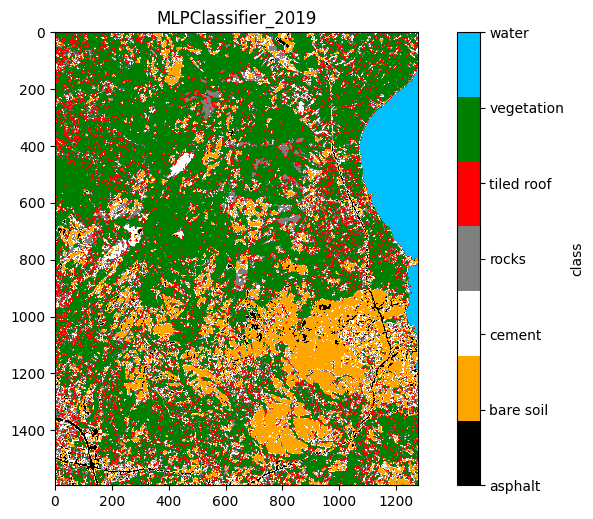

In [98]:
img_2019 = mpimg.imread(rgb_fp_2019) 
# fig, axs = plt.subplots(2,1,figsize=(15,15),dpi= 300)

plt.figure(figsize=(10,6),dpi=100)

cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

predict_plot = plt.imshow(y_pred_img_2019, cmap=cmap)
cbar = plt.colorbar(predict_plot, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
plt.title(classifier_name_2019)

**Image 2020**

Text(0.5, 1.0, 'KNN_layers_2020')

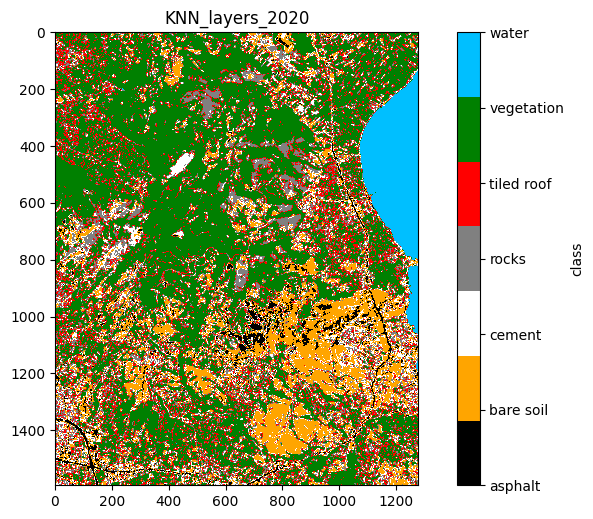

In [100]:
img_2020 = mpimg.imread(rgb_fp_2020) 
# fig, axs = plt.subplots(2,1,figsize=(15,15),dpi= 300)

plt.figure(figsize=(10,6),dpi=100)

cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

predict_plot = plt.imshow(y_pred_img_2020, cmap=cmap)
cbar = plt.colorbar(predict_plot, label='class')
cbar.set_ticks(np.arange(0, len(labels)))
cbar.set_ticklabels(labels)
plt.title(classifier_name_2020)

**The following three cells show the rgb images together with the classified**

In [101]:
# from matplotlib import colors
# img_2016 = mpimg.imread(rgb_fp_2016) 

# fig, axs = plt.subplots(2,1,figsize=(12,12),dpi= 200)

# axs[0].imshow(img_2016)
# axs[0].set_axis_off()
# cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

# predict_plot = axs[1].imshow(y_pred_img_2016, cmap=cmap)
# cbar = fig.colorbar(predict_plot, ax=axs[1], label='class')
# cbar.set_ticks(np.arange(0, len(labels)))
# cbar.set_ticklabels(labels)
# axs[1].set_title(classifier_name_2016)
# axs[1].set_axis_off()

In [102]:
# img_2019 = mpimg.imread(rgb_fp_2019) 
# fig, axs = plt.subplots(2,1,figsize=(15,15),dpi= 300)

# axs[0].imshow(img_2019)
# axs[0].set_axis_off()
# cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

# predict_plot = axs[1].imshow(y_pred_img_2019, cmap=cmap)
# cbar = fig.colorbar(predict_plot, ax=axs[1], label='class')
# cbar.set_ticks(np.arange(0, len(labels)))
# cbar.set_ticklabels(labels)
# axs[1].set_title(classifier_name_2019)
# axs[1].set_axis_off()

In [103]:
# img_2020 = mpimg.imread(rgb_fp_2020) 
# fig, axs = plt.subplots(2,1,figsize=(15,15),dpi= 300)

# axs[0].imshow(img_2020)
# axs[0].set_axis_off()
# cmap = colors.ListedColormap(['black','orange','white','grey','red','green','deepskyblue'])

# predict_plot = axs[1].imshow(y_pred_img_2020, cmap=cmap)
# cbar = fig.colorbar(predict_plot, ax=axs[1], label='class')
# cbar.set_ticks(np.arange(0, len(labels)))
# cbar.set_ticklabels(labels)
# axs[1].set_title(classifier_name_2020)
# axs[1].set_axis_off()

**(e) Compare and discuss the results of your predicted land use labels in the three different scenes. Were there any problems? Do you note any clear land cover changes? Is this real change or error in the model?**

During the process of the classification the algorithm examines the spectral characteristics of all the pixels in the image and, based on certain assumptions, classifies them into some spectral category.There are several classifiers that are based on different algorithms. In this project three classifier were used: SVC, KNN and MLPClassifier.

The digital image consists of a high number of pixels which represents the brightness of a small region on the Earth's surface (in our case 10mX10m), recorded digitally as a numeric value, usually with seperate values for each of several regions of the electromagnetic spectrum (Campbell, 2007). Since there is often more than one feature in the field of view, the response of the detector will be an average of the responses from the individual features weighted according to the portion that they occupy within the field of view (Jones & Vaughan, 2010). That means that in the area of the 100 sq.m., that responses to the resolution of the images (Image 2016, 2019,2020) there are more than one fetaure.

According to the val_accuracy the first image (2016) should give better result (MLPClassifier_2016 = 0.983889, MLPClassifier_2019 = 0.952537, KNN_2020 = 0.943053). However by visual observation, some categories, such as asphalt (roads), are represented in more detail in the second (2019) and especially in the third image (2020). A better capture of this label (asphalt), in the second and third image, creates other problems which will be analyzed below. Generally all three classifications attach well the land cover of the region and in some cases highlight details that are difficult to identify in the RGB image. 

In relation to the 2016 image, there are two main mistakes / failures. The first mistake has to do with asphalt stains. There are some areas of ashalts instead of rocky areas. In other words, there is an overlap of asphalt and rocks. The second problem is related with the blue spot that represents the water. This problem derives from the cloud shadow that exists in that area. Other minor errors are related to small areas of arable land that have been identified as tiled roofs. Also the limestone (at the mountain) is categorized as cement, but the white material of the limestone is closer to the legend cement than the others. In this case there should be an additional category. It has to be mentioned that many times groups, which usually occupy a small area, may remain unrecognized in the process of the classification and may  integrate into other classes, creating errors and inaccuracies. A case in point is the limestone and some dirt roads that classify as cement and bare soil respectively. 

The image 2019 experiences similar mistakes like the first image. In this case the there is not the blue spot that correspond to the water like in the image 2016. Moreover there are less mistakes in terms of the tiled roofs and the bare soil and the road network is represented better.

In the last image 2020 the road network representation is even better than the others. As is mentioned above this created more asphalt spots in areas that are rocks or bare soil. One other factor that some small areas are classified as asphalt is the fire that broke out in 2018 and changed the composition of the soil. For that reason another class had to be added for the images 2019 and 2020.

In terms of to what changes are observed in the three images these are related mainly to the vegetation. The second image experiences more vegetation apart from an area at southeast, where the vegation has been replaced by the bare soil.The class of the vegetation contains trees, bushes, grass and herbaceous vegetation. The last two can easily change from one year to the other. It is known that the spectral structure of many biophysical elements, and especially vegetation, is not stable, due to phenological changes, changes in lighting, humidity and due to the weather condition in general. This justifies the fact that vegetation occupies a larger area, as a class, in the second and third image. A significant change that appears in the second and the third image is the replacement of the vegetation by the bare soil in and around the settlement to the southeast. This change of land cover caused by a big fire that took place in July of 2018. In conclusion these changes are caused by real, physical factors and not by errors in model.